In [15]:
import numpy as np
import torch
import local_utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from local_utils import ResidualBlock
from torch import nn
import cv2
from pathlib import Path
from collections import OrderedDict
from types import SimpleNamespace
import torch.quantization
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

image_size = (640, 480)

In [16]:
print("start")

start


# 1. Dane ewaluacyjne

Liczba obrazów w zbiorze testowym: 5


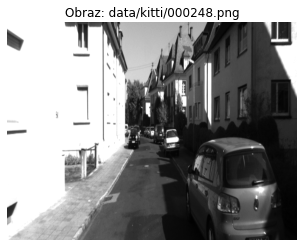

In [17]:
class SuperPointDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_paths = [str(f) for f in Path(image_folder).iterdir()][:5]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, image_size)
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

transform = transforms.Compose([transforms.ToTensor()])

test_dataset = SuperPointDataset("./data/kitti", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(f"Liczba obrazów w zbiorze testowym: {len(test_dataset)}")
# Wyświetlanie jednego obrazu z test_loader
image, path = test_dataset[0]  # Wybieramy pierwszy obraz
image = image.squeeze(0)  # Usuwamy wymiar kanału (1, H, W)
image = image.numpy()  # Konwertujemy tensor na numpy array

# Wyświetlanie obrazu
plt.imshow(image, cmap='gray')
plt.title(f"Obraz: {path}")
plt.axis('off')  # Ukrycie osi
plt.show()

In [81]:

def crop_center(image, crop_width=640, crop_height=480):
    h, w = image.shape[:2]
    if crop_width > w or crop_height > h:
        raise ValueError("Crop size larger than image.")
    x0 = (w - crop_width) // 2
    y0 = (h - crop_height) // 2
    cropped = image[y0:y0+crop_height, x0:x0+crop_width]
    return cropped, (x0, y0)

def crop_matrix(offset):
    x0, y0 = offset
    return np.array([
        [1, 0, -x0],
        [0, 1, -y0],
        [0, 0, 1]
    ], dtype=np.float32)

class HPatchesCroppedDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.root_dir = root_dir

        for scene in os.listdir(root_dir):
            scene_path = os.path.join(root_dir, scene)
            if not os.path.isdir(scene_path):
                continue

            ref_path = os.path.join(scene_path, '1.ppm')
            ref_img = cv2.imread(ref_path, cv2.IMREAD_COLOR)
            if ref_img is None or ref_img.shape[1] < 640 or ref_img.shape[0] < 480:
                continue

            for i in range(2, 7):  # max 6 obrazów
                tgt_path = os.path.join(scene_path, f'{i}.ppm')
                H_path = os.path.join(scene_path, f'H_1_{i}')

                if not os.path.exists(tgt_path) or not os.path.exists(H_path):
                    continue

                self.samples.append((ref_path, tgt_path, H_path, scene))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ref_path, tgt_path, H_path, scene = self.samples[idx]

        # Wczytaj obrazy
        img1 = cv2.imread(ref_path, cv2.IMREAD_COLOR)
        img2 = cv2.imread(tgt_path, cv2.IMREAD_COLOR)

        if img1 is None or img2 is None:
            raise ValueError("Błąd wczytywania obrazu.")

        # Przytnij środek obrazu
        img1_crop, offset1 = crop_center(img1)
        img2_crop, offset2 = crop_center(img2)

        # Przekształć na szaro i float32 [0, 1]
        img1_pre = img1_crop.mean(-1) / 255.0
        img2_pre = img2_crop.mean(-1) / 255.0

        # Wczytaj i zaktualizuj homografię
        H = np.loadtxt(H_path).astype(np.float32)
        T1 = crop_matrix(offset1)
        T2 = crop_matrix(offset2)
        H_updated = T1 @ H @ np.linalg.inv(T2)

        # Na tensor [1, H, W]
        img1_tensor = torch.from_numpy(img1_pre).unsqueeze(0).float()
        img2_tensor = torch.from_numpy(img2_pre).unsqueeze(0).float()

        return img1_tensor, img2_tensor, H_updated, scene
dataset = HPatchesCroppedDataset('./data/hpatch-release/hpatch-release/')
print(f"Liczba obrazów w zbiorze testowym: {len(dataset)}")
HP_loader = DataLoader(dataset, batch_size=1, shuffle=False)


Liczba obrazów w zbiorze testowym: 500


# 2. Inicjalizacja modelu zmiennoprzecinkowego

In [19]:
def sample_descriptors(keypoints, descriptors, s: int = 8):
    """Interpolate descriptors at keypoint locations"""
    b, c, h, w = descriptors.shape
    keypoints = (keypoints + 0.5) / (keypoints.new_tensor([w, h]) * s)
    keypoints = keypoints * 2 - 1  # normalize to (-1, 1)
    descriptors = torch.nn.functional.grid_sample(
        descriptors, keypoints.view(b, 1, -1, 2), mode="bilinear", align_corners=False
    )
    descriptors = torch.nn.functional.normalize(
        descriptors.reshape(b, c, -1), p=2, dim=1
    )
    return descriptors


def batched_nms(scores, nms_radius: int):
    assert nms_radius >= 0

    def max_pool(x):
        return torch.nn.functional.max_pool2d(
            x, kernel_size=nms_radius * 2 + 1, stride=1, padding=nms_radius
        )

    zeros = torch.zeros_like(scores)
    max_mask = scores == max_pool(scores)
    for _ in range(2):
        supp_mask = max_pool(max_mask.float()) > 0
        supp_scores = torch.where(supp_mask, zeros, scores)
        new_max_mask = supp_scores == max_pool(supp_scores)
        max_mask = max_mask | (new_max_mask & (~supp_mask))
    return torch.where(max_mask, scores, zeros)


def select_top_k_keypoints(keypoints, scores, k):
    if k >= len(keypoints):
        return keypoints, scores
    scores, indices = torch.topk(scores, k, dim=0, sorted=True)
    return keypoints[indices], scores


class VGGBlock(nn.Sequential):
    def __init__(self, c_in, c_out, kernel_size, relu=True):
        padding = (kernel_size - 1) // 2
        conv = nn.Conv2d(
            c_in, c_out, kernel_size=kernel_size, stride=1, padding=padding
        )
        activation = nn.ReLU(inplace=True) if relu else nn.Identity()
        bn = nn.BatchNorm2d(c_out, eps=0.001)
        super().__init__(
            OrderedDict(
                [
                    ("conv", conv),
                    ("activation", activation),
                    ("bn", bn),
                ]
            )
        )


class SuperPointNet(nn.Module):
    """ Pytorch definition of SuperPoint Network. """
    default_conf = {
        "nms_radius": 4,
        "max_num_keypoints": 500,
        "detection_threshold": 0.005,
        "remove_borders": 4,
        "descriptor_dim": 256,
        "channels": [64, 64, 128, 128, 256],
    }
    def __init__(self, **conf):
        super(SuperPointNet, self).__init__()

        conf = {**self.default_conf, **conf}
        self.conf = conf
        self.stride = 2 ** (len(self.conf["channels"]) - 2)

        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        
        self.relu = torch.nn.ReLU(inplace=True)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.relu2 = torch.nn.ReLU(inplace=True)
        self.relu3 = torch.nn.ReLU(inplace=True)
        self.relu4 = torch.nn.ReLU(inplace=True)
        self.relu5 = torch.nn.ReLU(inplace=True)
        self.relu6 = torch.nn.ReLU(inplace=True)
        self.relu7 = torch.nn.ReLU(inplace=True)
        self.relu8 = torch.nn.ReLU(inplace=True)
        self.relu9 = torch.nn.ReLU(inplace=True)
        self.relu10 = torch.nn.ReLU(inplace=True)
        
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = torch.nn.Conv2d(
            1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = torch.nn.Conv2d(
            c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = torch.nn.Conv2d(
            c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = torch.nn.Conv2d(
            c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = torch.nn.Conv2d(
            c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = torch.nn.Conv2d(
            c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = torch.nn.Conv2d(
            c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = torch.nn.Conv2d(
            c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = torch.nn.Conv2d(
            c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = torch.nn.Conv2d(
            c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = torch.nn.Conv2d(
            c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = torch.nn.Conv2d(
            c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """ Forward pass that jointly computes unprocessed point and descriptor
        tensors.
        Input
        x: Image pytorch tensor shaped N x 1 x H x W.
        Output
        semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
        desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
        """
        # Shared Encoder.
        x = self.quant(x)
        x = self.relu1(self.conv1a(x))
        x = self.relu2(self.conv1b(x))
        x = self.pool1(x)
        x = self.relu3(self.conv2a(x))
        x = self.relu4(self.conv2b(x))
        x = self.pool2(x)
        x = self.relu5(self.conv3a(x))
        x = self.relu6(self.conv3b(x))
        x = self.pool3(x)
        x = self.relu7(self.conv4a(x))
        x = self.relu8(self.conv4b(x))
        # Detector Head.
        cPa = self.relu9(self.convPa(x))
        semi = self.convPb(cPa)
       # scores = torch.nn.functional.softmax(semi, 1)
        # Descriptor Head.
        cDa = self.relu10(self.convDa(x))
        desc = self.convDb(cDa)
   #     dn = torch.norm(desc, p=2, dim=1)  # Compute the norm.
    #    desc = desc.div(torch.unsqueeze(dn, 1))  # Divide by norm to normalize.
     #   desc = torch.nn.functional.normalize(desc, p=2, dim=1, eps=1e-6)
        return self.dequant(semi), self.dequant(desc)

In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
detection_thresh = 0.005
nms_radius = 5

float_model = SuperPointNet(detection_threshold=detection_thresh, nms_radius=nms_radius).eval()
float_model.load_state_dict(torch.load("superpoint_v1.pth"))
# conf = float_model.conf
input_shape = (1, 1, image_size[1], image_size[0])
model = float_model.to(device)

print(device)

cpu


# Inspector model

In [7]:
import pytorch_nndct
print(pytorch_nndct.__version__)
from pytorch_nndct.apis import Inspector
target = "0x1000020F6014407"

inspector = Inspector(target)
rand_in = torch.randn(input_shape).to(device)
inspector.inspect(model, (rand_in,), device=device, output_dir="inspect", image_format="png")


[VAIQ_NOTE]: Loading NNDCT kernels...


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


3.5.0+60df3f1+torch1.13.1


ModuleNotFoundError: No module named 'tabulate'

# Postprocessing

In [21]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(torch.__version__)

detection_thresh = 0.005
nms_radius = 5

def match_descriptors(kp1, desc1, kp2, desc2):
    # Match the keypoints with the warped_keypoints with nearest neighbor search
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    matches = bf.match(desc1, desc2)
    matches_idx = np.array([m.queryIdx for m in matches])
    m_kp1 = [kp1[idx] for idx in matches_idx]
    matches_idx = np.array([m.trainIdx for m in matches])
    m_kp2 = [kp2[idx] for idx in matches_idx]

    return m_kp1, m_kp2, matches

def compute_homography(matched_kp1, matched_kp2):
    matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC)
    inliers = inliers.flatten()
    return H, inliers

def preprocess_image(img_file, img_size):
    img = cv2.imread(img_file, cv2.IMREAD_COLOR)
    # img = cv2.resize(img, img_size)
    img_orig = img.copy()
    img_preprocessed = img.mean(-1) / 255
    #img_preprocessed = np.pad(image, [(0, int(np.ceil(s/8))*8 - s) for s in image.shape[:2]])

    return img_preprocessed, img_orig

def post_processing_short(scores, descriptors_dense, conf):
    b = scores.shape[0]
    scores = batched_nms(scores, conf['nms_radius'])

    # Discard keypoints near the image borders
    if conf['remove_borders']:
        pad = conf['remove_borders']
        scores[:, :pad] = -1
        scores[:, :, :pad] = -1
        scores[:, -pad:] = -1
        scores[:, :, -pad:] = -1

    scores = scores.squeeze(0)
    idxs = torch.where(scores > conf['detection_threshold'])

    # Convert (i, j) to (x, y)
    keypoints_all = torch.stack(idxs[-2:], dim=-1).flip(1).float()
    scores_all = scores[idxs]

    keypoints = []
    scores = []
    descriptors = []
    for i in range(b):
        if b > 1:
            k = keypoints_all[mask[i]]
            s = scores_all[mask[i]]
        else:
            k = keypoints_all
            s = scores_all
        if conf['max_num_keypoints'] is not None:
            k, s = select_top_k_keypoints(k, s, conf['max_num_keypoints'])
        d = sample_descriptors(k[None], descriptors_dense[i, None], 2 ** (len(conf['channels']) - 2))
        keypoints.append(k)
        scores.append(s)
        descriptors.append(d.squeeze(0).transpose(0, 1))

    return {
        "keypoints": keypoints,
        "keypoint_scores": scores,
        "descriptors": descriptors,
    }


def show_comparison(tensors1, tensors2, img1_orig, img2_orig, model):

    # Run inference for both images
    tensors = [tensors1, tensors2]
    keypoints_list = []
    desc_list = []

    for tensor in tensors:
        pred_th_1 = post_processing_short(tensor['scores'], tensor['descriptors_dense'], model.conf)
        descriptors = pred_th_1['descriptors'][0]
        points_th = pred_th_1['keypoints'][0]
        keypoints_np = np.array(points_th.cpu().detach().numpy())  # Konwersja do NumPy
        keypoints = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in keypoints_np]
        keypoints_list.append(keypoints)
        desc_list.append(descriptors.cpu().detach().numpy().astype(np.float32)
)

    m_kp1, m_kp2, matches = match_descriptors(keypoints_list[0], desc_list[0], keypoints_list[1], desc_list[1])
    H, inliers = compute_homography(m_kp1, m_kp2)

    # Draw SuperPoint matches
    matches = np.array(matches)[inliers.astype(bool)].tolist()
    print(len(matches))

    matched_img = cv2.drawMatches(img1_orig, keypoints_list[0], img2_orig, keypoints_list[1], matches,
                                    None, matchColor=(0, 255, 0),
                                    singlePointColor=(0, 0, 255))

    return matched_img

def visualize(model, data_folder, text, image_size=image_size):
    img1 = cv2.imread(f'data/kitti/000000.png', cv2.IMREAD_COLOR)
    img1 = cv2.resize(img1, image_size)
    img2 = cv2.imread(f'data/kitti/000001.png', cv2.IMREAD_COLOR)
    img2 = cv2.resize(img2, image_size)
    data0 = torch.load(data_folder + f'outputs_batch_0.pt')
    data1 = torch.load(data_folder + f'outputs_batch_1.pt')
    matched = show_comparison(data0, data1, img1, img2, model)
    matched_rgb = cv2.cvtColor(matched, cv2.COLOR_BGR2RGB)
    # Wyświetlenie obrazu w Jupyter Notebook
    plt.figure(figsize=(10, 5))
    plt.imshow(matched_rgb)
    plt.title(text)
    plt.axis("off")  # Ukrycie osi
    plt.show()

1.10.1


# Ewaluacja modelu zmiennoprzecinkowego

In [22]:
def evaluate(model, dataloader, device, conf=0.5):
    """
    Porównuje działanie modelu przed i po kwantyzacji.

    :param float_model: model przed kwantyzacją
    :param quantized_model: model po kwantyzacji
    :param dataloader: zbiór testowy
    :param device: urządzenie (CPU/GPU)
    """
    tm = local_utils.TimeMeasurement("Evaluation", len(dataloader))
    
    model.to(device).eval()

    diff_total, count = 0, 0
    tensors = []
    with torch.no_grad(), tm:
        for i, (X, *Y) in enumerate(dataloader):
            X = X.to(device)
            # Forward pass dla modeli
            scores, descriptors_dense = model(X)
            scores = torch.nn.functional.softmax(scores, 1)[:, :-1]
            b, _, h, w = scores.shape
            scores = scores.permute(0, 2, 3, 1).reshape(b, h, w, 8, 8)
            scores = scores.permute(0, 1, 3, 2, 4).reshape(
                b, h * 8, w * 8
            )
            keypoints = post_processing_short(scores, descriptors_dense, conf)['keypoints']
            data = torch.load(f'data/kitti_processed/outputs_batch_{i}.pt')
            data_post = post_processing_short(data['scores'], data['descriptors_dense'], conf)
            data_keypoints = data_post['keypoint_scores']
       #     torch.save({'scores': scores, 'descriptors_dense': descriptors_dense}, f'outputs_batch_{i}.pt')
            print(keypoints[0].shape[0])
            # Obliczenie różnicy
            percent_diff = keypoints[0].shape[0]/data_keypoints[0].shape[0]
            # Aktualizacja wyników
            batch_size = X.shape[0]
            diff_total += percent_diff
            count += batch_size

            print(f"\rEvaluation {i+1}/{len(dataloader)} | keypoints_loss: {percent_diff:.6f}", end='')

    # Średnie wyniki
    diff_avg = diff_total / count
    print(f"\nFinal Evaluation: keypoints_loss = {diff_avg:.6f}")
    print(tm)

    return diff_avg

def create_data(model, dataloader, device, conf=0.5):
    """
    Porównuje działanie modelu przed i po kwantyzacji.

    :param float_model: model przed kwantyzacją
    :param quantized_model: model po kwantyzacji
    :param dataloader: zbiór testowy
    :param device: urządzenie (CPU/GPU)
    """
    tm = local_utils.TimeMeasurement("Evaluation", len(dataloader))
    
    model.to(device).eval()

    diff_total, count = 0, 0
    tensors = []
    with torch.no_grad(), tm:
        for i, (X, *Y) in enumerate(dataloader):
            X = X.to(device)
            # Forward pass dla modeli
            scores, descriptors_dense = model(X)
            scores = torch.nn.functional.softmax(scores, 1)[:, :-1]

            b, _, h, w = scores.shape
            scores = scores.permute(0, 2, 3, 1).reshape(b, h, w, 8, 8)
            scores = scores.permute(0, 1, 3, 2, 4).reshape(
                b, h * 8, w * 8
            )
            keypoints = post_processing_short(scores, descriptors_dense, conf)['keypoints']
            
            torch.save({'scores': scores, 'descriptors_dense': descriptors_dense}, f'data/kitti_processed/outputs_batch_{i}.pt')
            # Obliczenie różnicy
            percent_diff = keypoints[0].shape[0]
            # Aktualizacja wyników
            batch_size = X.shape[0]
            diff_total += percent_diff
            count += batch_size

            print(f"\rEvaluation {i+1}/{len(dataloader)} | keypoints_loss: {percent_diff:.6f}", end='')

    # Średnie wyniki
    diff_avg = diff_total / count
    print(f"\nFinal Evaluation: keypoints_loss = {diff_avg:.6f}")
    print(tm)

    return diff_avg

In [23]:
create_data(model, test_loader, device, model.conf)


Evaluation 5/5 | keypoints_loss: 500.000000
Final Evaluation: keypoints_loss = 500.000000
Execution time: 0.0:0.0:3:676, processed 5 frames, throughput: 1.3601723823816676 fps.


500.0

Na potrzeby ewaluacji wykorzystuje się wcześniej wyliczone wyniki na modelu zmiennprzecinkowym

In [10]:
visualize(float_model, "data/", "Originalny wynik", image_size=image_size)

NameError: name 'visualize' is not defined

In [52]:
# You can evaluate your floating point model first 
evaluate(model, test_loader, device, model.conf)
visualize(float_model,"", "Wynik zmiennoprzecinkowy")

225
Evaluation 1/250 | keypoints_loss: 1.000000235
Evaluation 2/250 | keypoints_loss: 1.000000225
Evaluation 3/250 | keypoints_loss: 1.000000236
Evaluation 4/250 | keypoints_loss: 1.000000232
Evaluation 5/250 | keypoints_loss: 1.000000219
Evaluation 6/250 | keypoints_loss: 1.000000230
Evaluation 7/250 | keypoints_loss: 1.000000213
Evaluation 8/250 | keypoints_loss: 1.000000227
Evaluation 9/250 | keypoints_loss: 1.000000229
Evaluation 10/250 | keypoints_loss: 1.000000225
Evaluation 11/250 | keypoints_loss: 1.000000279
Evaluation 12/250 | keypoints_loss: 1.000000231
Evaluation 13/250 | keypoints_loss: 1.000000226
Evaluation 14/250 | keypoints_loss: 1.000000261
Evaluation 15/250 | keypoints_loss: 1.000000259
Evaluation 16/250 | keypoints_loss: 1.000000265
Evaluation 17/250 | keypoints_loss: 1.000000245
Evaluation 18/250 | keypoints_loss: 1.000000250
Evaluation 19/250 | keypoints_loss: 1.000000242
Evaluation 20/250 | keypoints_loss: 1.000000229
Evaluation 21/250 | keypoints_loss: 1.0000002

FileNotFoundError: [Errno 2] No such file or directory: 'outputs_batch_0.pt'

# 4. Kwantyzacja modelu zmiennoprzecinkowego

In [24]:
def compute_sequence(image_folder, model,float_model, tryb='show'):
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith((".png", ".jpg", ".ppm"))])
    first_image = cv2.imread(os.path.join(image_folder, image_files[0]))
    height, width, _ = first_image.shape
    past_descriptors = None
    past_keypoints = None
    for i in range(0, len(image_files), 3):
        image_file = image_files[i]
        image_path = os.path.join(image_folder, image_file)
        image, img_orig = preprocess_image(image_path, image_size)
        scores, descriptors_dense = model(torch.from_numpy(image[None, None]).float())
        scores = torch.nn.functional.softmax(scores, 1)[:, :-1]
        b, _, h, w = scores.shape
        scores = scores.permute(0, 2, 3, 1).reshape(b, h, w, 8, 8)
        scores = scores.permute(0, 1, 3, 2, 4).reshape(
            b, h * 8, w * 8
        )
        pred_th_1 = post_processing_short(scores, descriptors_dense, float_model.conf)
        descriptors = pred_th_1['descriptors'][0].cpu().detach().numpy().astype(np.float32)
        points_th = pred_th_1['keypoints'][0]
        keypoints_np = np.array(points_th.cpu().detach().numpy())  # Konwersja do NumPy
        keypoints = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in keypoints_np]
        if past_descriptors is not None:
            m_kp1, m_kp2, matches = match_descriptors(past_keypoints, past_descriptors, keypoints, descriptors)
            H, inliers = compute_homography(m_kp1, m_kp2)
            matches = np.array(matches)[inliers.astype(bool)].tolist()

            for match in matches:
                pt1 = tuple(map(int, past_keypoints[match.queryIdx].pt))
                pt2 = tuple(map(int, keypoints[match.trainIdx].pt))
                cv2.arrowedLine(img_orig, pt2, pt1, (0, 255, 0), 1, tipLength=0.2)

        past_descriptors = descriptors
        past_keypoints = keypoints
        if tryb=='show':
            cv2.imshow("Film", img_orig)
            
            # Czekaj 30 ms na kolejny obraz (około 30 FPS)
            if cv2.waitKey(30) & 0xFF == ord('q'):
                break  # Wyjście z pętli po naciśnięciu 'q'
        else:
            cv2.imwrite("./data/matched/" + image_file, img_orig)
    if tryb=='show':
        cv2.destroyAllWindows()
        
def get_film(image_folder):
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])

    # Ustalamy rozmiar wideo na podstawie pierwszego obrazu
    first_image = cv2.imread(os.path.join(image_folder, image_files[0]))
    height, width, _ = first_image.shape

    # Nazwa pliku wynikowego wideo
    output_video = 'original.mp4'

    # Tworzymy obiekt VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Wybór kodeka
    fps = 10  # Liczba klatek na sekundę
    video_writer = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    # Dodajemy obrazy do wideo
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        video_writer.write(image)

    # Zwolnienie zasobów
    video_writer.release()

    print(f"Film zapisany jako {output_video}")

In [25]:
def quantize(float_model:torch.nn.Module, 
             input_shape:tuple,
             quant_dir:str, 
             quant_mode:str, 
             device:torch.device,
             dataloader):
    """
    :param float_model: float model with loaded weights
    :param input_shape: shape of input(CH,W,H)
    :param quant_dir: path to directory with quantized model components
    :param quant_mode: quant_mode in ['calib', 'test'] 
    :param data_loader: data_loader - for 'calib' must be batch_size == 1
    :param evaluator: fcn/obj like: fcn(y_pred, y_ref) -> float 
    """
    tm = local_utils.TimeMeasurement("Quantization", len(dataloader))
    from pytorch_nndct.apis import torch_quantizer, dump_xmodel
    print(f"Input shape: {input_shape}")
    with tm:
        # model to device
        model = float_model.to(device)

        # Force to merge BN with CONV for better quantization accuracy
        optimize = 1

        rand_in = torch.randn(input_shape)
        print("get qunatizer start")
        try:
            quantizer = torch_quantizer(
                quant_mode, model, rand_in, output_dir=quant_dir, device=device)
        except Exception as e:
            print("exception:")
            print(e)
            return
        print("get qunatizer end")

        print("get quantized model start")
        quantized_model = quantizer.quant_model
        print("get quantized model end")

        # evaluate
        print("testing start")
        diff = evaluate(quantized_model, dataloader, device, float_model.conf)
        print(f"Testing finished: diff = {diff:.6f}")
        print("testing end")

        # export config
        if quant_mode == 'calib':
            print("export config")
            quantizer.export_quant_config()
            print("export config end")
        # export model
        if quant_mode == 'test':
            print("export xmodel")
          #  visualize(float_model, "", "Wynik po kwantyzacji")
            quantizer.export_xmodel(deploy_check=False, output_dir=quant_dir)
            #compute_sequence("/workspace/SuperPoint/data/rgbd_dataset_freiburg1_xyz/rgb", quantized_model, model, tryb='save')            
            print("export xmodel end")
    print(tm)
    return quantized_model

In [26]:
quantize(float_model=model, 
         input_shape=input_shape,
         quant_dir='quant_dir', # directory for quantizer results
         quant_mode='calib',
         device=device,
         dataloader=test_loader)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'

[VAIQ_NOTE]: Loading NNDCT kernels...
Input shape: (1, 1, 480, 640)
get qunatizer start

[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization calibration process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cpu'.

[VAIQ_NOTE]: =>Parsing SuperPointNet...

[VAIQ_NOTE]: Start to trace model...

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 27/27 [00:00<00:00, 256.34it/s, OpInfo: name = return_0, type = Return]                      


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(quant_dir/SuperPointNet.py)


get qunatizer end
get quantized model start

[VAIQ_NOTE]: =>Get module with quantization.
get quantized model end
testing start
500
Evaluation 1/5 | keypoints_loss: 1.000000500
Evaluation 2/5 | keypoints_loss: 1.000000500
Evaluation 3/5 | keypoints_loss: 1.000000500
Evaluation 4/5 | keypoints_loss: 1.000000500
Evaluation 5/5 | keypoints_loss: 1.000000
Final Evaluation: keypoints_loss = 1.000000
Execution time: 0.0:0.0:47:167, processed 5 frames, throughput: 0.10600546855565335 fps.
Testing finished: diff = 1.000000
testing end
export config

[VAIQ_NOTE]: =>Exporting quant config.(quant_dir/quant_info.json)
export config end
Execution time: 0.0:0.0:48:746, processed 5 frames, throughput: 0.10257251816072055 fps.


SuperPointNet(
  (module_0): deephi_Input()
  (module_1): deephi_Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (module_2): deephi_ReLU(inplace=True)
  (module_3): deephi_Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (module_4): deephi_ReLU(inplace=True)
  (module_5): deephi_MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=[0, 0], dilation=[1, 1], ceil_mode=False)
  (module_6): deephi_Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (module_7): deephi_ReLU(inplace=True)
  (module_8): deephi_Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (module_9): deephi_ReLU(inplace=True)
  (module_10): deephi_MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=[0, 0], dilation=[1, 1], ceil_mode=False)
  (module_11): deephi_Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (module_12): deephi_ReLU(inplace=True)
  (module_13): deephi_Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [27]:
quantized_model = quantize(float_model=model, 
         input_shape=input_shape,
         quant_dir='quant_dir', # directory for quantizer results
         quant_mode='test',
         device=device,
         dataloader=test_loader)

Input shape: (1, 1, 480, 640)
get qunatizer start

[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization test process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cpu'.

[VAIQ_NOTE]: =>Parsing SuperPointNet...

[VAIQ_NOTE]: Start to trace model...

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 27/27 [00:00<00:00, 459.94it/s, OpInfo: name = return_0, type = Return]                      


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(quant_dir/SuperPointNet.py)
get qunatizer end
get quantized model start

[VAIQ_NOTE]: =>Get module with quantization.
get quantized model end
testing start


500
Evaluation 1/5 | keypoints_loss: 1.000000500
Evaluation 2/5 | keypoints_loss: 1.000000500
Evaluation 3/5 | keypoints_loss: 1.000000500
Evaluation 4/5 | keypoints_loss: 1.000000500
Evaluation 5/5 | keypoints_loss: 1.000000
Final Evaluation: keypoints_loss = 1.000000
Execution time: 0.0:0.0:7:151, processed 5 frames, throughput: 0.6991951670011802 fps.
Testing finished: diff = 1.000000
testing end
export xmodel

[VAIQ_NOTE]: =>Converting to xmodel ...

[VAIQ_NOTE]: =>Successfully convert 'SuperPointNet' to xmodel.(quant_dir/SuperPointNet_int.xmodel)
export xmodel end
Execution time: 0.0:0.0:9:221, processed 5 frames, throughput: 0.5421995625487996 fps.


Po testowaniu, należy skompilować model. Podajemy odpowiednio parametry:

- --xmodel - ścieżka do zapisanego modelu (zapisany jest w folderze podanym podczas kwantyzacji jako parametr 'quant_dir'
- --arch - podajemy plik arch.json, który znajdował się w pliku. Jest to numer (fingerprint), który określa typ DPU sprzętu docelowego
- --net_name - nazwa naszego modelu po kompilacji - dowolna
- --output_dir - folder do którego zapisany zostanie model

In [2]:
# compile model
# /opt/vitis_ai/compiler/arch/DPUCZDX8G/KV260/arch.json

!vai_c_xir --xmodel 'quant_dir/SuperPointNet_int_test_softmax_latest.xmodel' --arch arch_orig.json --net_name SuperPointNet_int_test_softmax_latest --output_dir build

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: function
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA0_B4096_MAX_BG2
[UNILOG][INFO] Graph name: SuperPointNet, with op num: 91
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 4, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG][INFO] The meta json is saved to "/workspace/build/meta.json"
[UNILOG][INFO] The compiled xmodel is saved to "/workspace/build/SuperPointNet_int_test_softmax_latest.xmodel"
[UNILOG][INFO] The compiled xmodel's md5sum is ae704f6f07837d4d878b60d158ad44da, and has been saved to "/workspace/build/md5sum.txt"


In [20]:
#!/opt/vitis_ai/conda/envs/vitis-ai-pytorch/bin ls

!xdputil xmodel build/SuperPoint_wasala_isa0_int8.xmodel -p 


#!xcompiler --xmodel 'quant_dir/SuperPointNet_int.xmodel' --arch arch_orig.json --output_dir build --dump --net_name SuperPoint_softmax_last


In [ ]:
import numpy as np
from os import path as osp
from glob import glob


def get_paths(exper_name):
    """
    Return a list of paths to the outputs of the experiment.
    """
    return glob(osp.join(EXPER_PATH, 'outputs/{}/*.npz'.format(exper_name)))


def compute_tp_fp(data, remove_zero=1e-4, distance_thresh=2, simplified=False):
    """
    Compute the true and false positive rates.
    """
    # Read data
    gt = np.where(data['keypoint_map'])
    gt = np.stack([gt[0], gt[1]], axis=-1)
    n_gt = len(gt)
    prob = data['prob_nms'] if 'prob_nms' in data.files else data['prob']

    # Filter out predictions with near-zero probability
    mask = np.where(prob > remove_zero)
    prob = prob[mask]
    pred = np.array(mask).T

    # When several detections match the same ground truth point, only pick
    # the one with the highest score  (the others are false positive)
    sort_idx = np.argsort(prob)[::-1]
    prob = prob[sort_idx]
    pred = pred[sort_idx]

    diff = np.expand_dims(pred, axis=1) - np.expand_dims(gt, axis=0)
    dist = np.linalg.norm(diff, axis=-1)
    matches = np.less_equal(dist, distance_thresh)

    tp = []
    matched = np.zeros(len(gt))
    for m in matches:
        correct = np.any(m)
        if correct:
            gt_idx = np.argmax(m)
            tp.append(not matched[gt_idx])
            matched[gt_idx] = 1
        else:
            tp.append(False)
    tp = np.array(tp, bool)
    if simplified:
        tp = np.any(matches, axis=1)  # keeps multiple matches for the same gt point
        n_gt = np.sum(np.minimum(np.sum(matches, axis=0), 1))  # buggy
    fp = np.logical_not(tp)
    return tp, fp, prob, n_gt


def div0(a, b):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
        idx = ~np.isfinite(c)
        c[idx] = np.where(a[idx] == 0, 1, 0)  # -inf inf NaN
    return c


def compute_pr(exper_name, **kwargs):
    """
    Compute precision and recall.
    """
    # Gather TP and FP for all files
    paths = get_paths(exper_name)
    tp, fp, prob, n_gt = [], [], [], 0
    for path in paths:
        t, f, p, n = compute_tp_fp(np.load(path), **kwargs)
        tp.append(t)
        fp.append(f)
        prob.append(p)
        n_gt += n
    tp = np.concatenate(tp)
    fp = np.concatenate(fp)
    prob = np.concatenate(prob)

    # Sort in descending order of confidence
    sort_idx = np.argsort(prob)[::-1]
    tp = tp[sort_idx]
    fp = fp[sort_idx]
    prob = prob[sort_idx]

    # Cumulative
    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    recall = div0(tp_cum, n_gt)
    precision = div0(tp_cum, tp_cum + fp_cum)
    recall = np.concatenate([[0], recall, [1]])
    precision = np.concatenate([[0], precision, [0]])
    precision = np.maximum.accumulate(precision[::-1])[::-1]
    return precision, recall, prob


def compute_mAP(precision, recall):
    """
    Compute average precision.
    """
    return np.sum(precision[1:] * (recall[1:] - recall[:-1]))


def loc_error_per_image(pred, gt):

        diff = np.expand_dims(pred, axis=1) - np.expand_dims(gt, axis=0)
        dist = np.linalg.norm(diff, axis=-1)
        dist = np.min(dist, axis=1)
        correct_dist = dist[np.less_equal(dist, distance_thresh)]
        return correct_dist
    
def warp_keypoints(keypoints, H):
    """
    :param keypoints:
    points:
        numpy (N, (x,y))
    :param H:
    :return:
    """
    num_points = keypoints.shape[0]
    homogeneous_points = np.concatenate([keypoints, np.ones((num_points, 1))],
                                        axis=1)
    warped_points = np.dot(homogeneous_points, np.transpose(H))
    return warped_points[:, :2] / warped_points[:, 2:]

def compute_repeatability(keypoints, warped_keypoints, shape, H, keep_k_points=300,
                          distance_thresh=3, verbose=False):
    """
    Compute the repeatability. The experiment must contain in its output the prediction
    on 2 images, an original image and a warped version of it, plus the homography
    linking the 2 images.
    """

    def filter_keypoints(points, shape):
        """ Keep only the points whose coordinates are
        inside the dimensions of shape. """
        """
        points:
            numpy (N, (x,y))
        shape:
            (y, x)
        """
        mask = (points[:, 0] >= 0) & (points[:, 0] < shape[1]) &\
               (points[:, 1] >= 0) & (points[:, 1] < shape[0])
        print(mask.shape)
        return points[mask, :]

    def keep_true_keypoints(points, H, shape):
        """ Keep only the points whose warped coordinates by H
        are still inside shape. """
        """
        input:
            points: numpy (N, (x,y))
            shape: (y, x)
        return:
            points: numpy (N, (x,y))
        """
        # warped_points = warp_keypoints(points[:, [1, 0]], H)
        warped_points = warp_keypoints(points[:, [0, 1]], H)
        # warped_points[:, [0, 1]] = warped_points[:, [1, 0]]
        mask = (warped_points[:, 0] >= 0) & (warped_points[:, 0] < shape[1]) &\
               (warped_points[:, 1] >= 0) & (warped_points[:, 1] < shape[0])
        return points[mask, :]

    def select_k_best(points, k):
        """ Select the k most probable points (and strip their proba).
        points has shape (num_points, 3) where the last coordinate is the proba. """
        sorted_prob = points
        if points.shape[1] > 2:
            sorted_prob = points[points[:, 2].argsort(), :2]
            start = min(k, points.shape[0])
            sorted_prob = sorted_prob[-start:, :]
        return sorted_prob

    # paths = get_paths(exper_name)
    localization_err = -1
    repeatability = []
    N1s = []
    N2s = []
    # for path in paths:
    # data = np.load(path)


    # Filter out predictions
    # keypoints = np.where(data['prob'] > 0)
    # prob = data['prob'][keypoints[0], keypoints[1]]
    # keypoints = np.stack([keypoints[0], keypoints[1]], axis=-1)
    # warped_keypoints = np.where(data['warped_prob'] > 0)
    # warped_prob = data['warped_prob'][warped_keypoints[0], warped_keypoints[1]]
    # warped_keypoints = np.stack([warped_keypoints[0],
    #                              warped_keypoints[1],
    #                              warped_prob], axis=-1)
    # keypoints = data['prob'][:, :2]

    print(keypoints.shape)
    warped_keypoints = keep_true_keypoints(warped_keypoints, np.linalg.inv(H),
                                           shape)
    print("dupa")
    print(warped_keypoints.shape)

    # Warp the original keypoints with the true homography
    true_warped_keypoints = keypoints
    # true_warped_keypoints[:,:2] = warp_keypoints(keypoints[:, [1, 0]], H)
    true_warped_keypoints[:,:2] = warp_keypoints(keypoints[:, :2], H) # make sure the input fits the (x,y)
    # true_warped_keypoints = np.stack([true_warped_keypoints[:, 1],
    #                                   true_warped_keypoints[:, 0],
    #                                   prob], axis=-1)
    true_warped_keypoints = filter_keypoints(true_warped_keypoints, shape)

    # Keep only the keep_k_points best predictions
    #warped_keypoints = select_k_best(warped_keypoints, keep_k_points)
    #true_warped_keypoints = select_k_best(true_warped_keypoints, keep_k_points)

    # Compute the repeatability
    N1 = true_warped_keypoints.shape[0]
    N2 = warped_keypoints.shape[0]
    N1s.append(N1)
    N2s.append(N2)
    true_warped_keypoints = np.expand_dims(true_warped_keypoints, 1)
    warped_keypoints = np.expand_dims(warped_keypoints, 0)
    # shapes are broadcasted to N1 x N2 x 2:
    norm = np.linalg.norm(true_warped_keypoints - warped_keypoints,
                          ord=None, axis=2)
    count1 = 0
    count2 = 0
    local_err1, local_err2 = None, None
    if N2 != 0:
        min1 = np.min(norm, axis=1)
        count1 = np.sum(min1 <= distance_thresh)
        # print("count1: ", count1)
        local_err1 = min1[min1 <= distance_thresh]
        # print("local_err1: ", local_err1)
    if N1 != 0:
        min2 = np.min(norm, axis=0)
        count2 = np.sum(min2 <= distance_thresh)
        local_err2 = min2[min2 <= distance_thresh]

    if N1 + N2 > 0:
        # repeatability.append((count1 + count2) / (N1 + N2))
        repeatability = (count1 + count2) / (N1 + N2)
    if count1 + count2 > 0:
        localization_err = 0
        if local_err1 is not None:
            localization_err += (local_err1.sum())/ (count1 + count2)
        if local_err2 is not None:
            localization_err += (local_err2.sum())/ (count1 + count2)
    else:
        repeatability = 0
    if verbose:
        pass
    # return np.mean(repeatability)
    return repeatability, localization_err

# Ewaluacja HPaches


In [88]:
def compute_homography(matched_kp1, matched_kp2):
    matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC)
    inliers = inliers.flatten()
    return H, inliers

def warp_keypoints_2(keypoints, H):
    pts = np.array([kp.pt for kp in keypoints], dtype=np.float32)
    pts = np.expand_dims(pts, axis=1)
    warped_pts = cv2.perspectiveTransform(pts, H)
    return warped_pts[:, 0, :]

def scale_homography(H, old_shape, new_shape):
    """
    Skaluje homografię H z przestrzeni old_shape (wys, szer) do new_shape.
    """
    h_old, w_old = old_shape
    h_new, w_new = new_shape

    sx = w_new / w_old
    sy = h_new / h_old

    S = np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0, 0, 1]
    ])
    S_inv = np.linalg.inv(S)

    H_scaled = S_inv @ H @ S
    return H_scaled

def compute_homography_accuracy(kp1, kp2, matches, H_gt, shape, correctness_thresh=3.0):
    if len(matches) < 4:
        return False

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    H_pred, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC)

    if H_pred is None:
        return False

    # Zamień narożniki obrazu przez H_gt i H_pred, porównaj przesunięcia
    corners = np.array([[0, 0, 1],
                            [0, shape[0] - 1, 1],
                            [shape[1] - 1, 0, 1],
                            [shape[1] - 1, shape[0] - 1, 1]])
    # corners = np.array([[0, 0, 1],
    #             [0, shape[1] - 1, 1],
    #             [shape[0] - 1, 0, 1],
    #             [shape[0] - 1, shape[1] - 1, 1]])
    real_warped_corners = np.dot(corners, np.transpose(H_gt))
    real_warped_corners = real_warped_corners[:, :2] / real_warped_corners[:, 2:]

    warped_corners = np.dot(corners, np.transpose(H_pred))
    warped_corners = warped_corners[:, :2] / warped_corners[:, 2:]

    mean_dist = np.mean(np.linalg.norm(real_warped_corners - warped_corners, axis=1))
    # correctness = float(mean_dist <= correctness_thresh)
    correctness = mean_dist <= correctness_thresh

    return correctness

def adjust_homography_for_crop(H, offset):
    """
    Zmodyfikuj homografię po wycięciu obrazu z przesunięciem offset = (x0, y0).
    """
    x0, y0 = offset
    T = np.array([
        [1, 0, -x0],
        [0, 1, -y0],
        [0, 0, 1]
    ])
    return H @ T

def crop_center(image, crop_width=640, crop_height=480):
    """
    Wytnij fragment o rozmiarze crop_width x crop_height ze środka obrazu.
    """
    h, w = image.shape[:2]

    # Upewnij się, że wycinek zmieści się w obrazie
    if crop_width > w or crop_height > h:
        raise ValueError("Rozmiar wycinka jest większy niż obraz")

    # Oblicz początkowy punkt wycinka (lewy górny róg)
    x0 = (w - crop_width) // 2
    y0 = (h - crop_height) // 2

    cropped = image[y0:y0+crop_height, x0:x0+crop_width]
    return cropped, (x0, y0)  # zwracamy też offset


def compute_repeatability_and_localization_error(kp1, kp2, shape, H, threshold=3):
    warped_kp1 = warp_keypoints_2(kp1, H)
    pts2 = np.array([kp.pt for kp in kp2], dtype=np.float32)
    h, w = shape

    valid = (
        (warped_kp1[:, 0] >= 0) & (warped_kp1[:, 0] < w) &
        (warped_kp1[:, 1] >= 0) & (warped_kp1[:, 1] < h)
    )
    warped_kp1 = warped_kp1[valid]

    if len(warped_kp1) == 0 or len(pts2) == 0:
        return 0.0, np.inf

    dists = np.linalg.norm(warped_kp1[:, np.newaxis, :] - pts2[np.newaxis, :, :], axis=2)
    min_dists = np.min(dists, axis=1)
    repeatable = np.sum(min_dists < threshold)
    repeatability = repeatable / len(kp1)

    loc_error = np.mean(min_dists[min_dists < threshold]) if repeatable > 0 else np.inf

    return repeatability, loc_error

def process_image(img_preprocessed, conf):
    scores, descriptors_dense = quantized_model(img_preprocessed)
    scores = torch.nn.functional.softmax(scores, 1)[:, :-1]
    b, _, h, w = scores.shape
    scores = scores.permute(0, 2, 3, 1).reshape(b, h, w, 8, 8)
    scores = scores.permute(0, 1, 3, 2, 4).reshape(
        b, h * 8, w * 8
    )
    pred_th_1 = post_processing_short(scores, descriptors_dense, conf)
    descriptors = pred_th_1['descriptors'][0].cpu().detach().numpy().astype(np.float32)
    points_th = pred_th_1['keypoints'][0]
    keypoints_np = np.array(points_th.cpu().detach().numpy())

    return keypoints_np, descriptors

def evaluate_folder(conf):
    Repeatability = []
    Localization = []
    Homography = []

    for img1, img2, H, scene in HP_loader:
        print(scene)
        H = np.array(H.cpu().detach().numpy())[0]
        scores1, desc1 = process_image(img1, conf)
        scores2, desc2 = process_image(img2, conf)
        kp1 = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in scores1]
        kp2 = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in scores2]
        image_size = (640, 480)
        repeat, loc_err = compute_repeatability(scores1, scores2, image_size, H)
        #repeat, loc_err = compute_repeatability_and_localization_error(kp1, kp_i, image_size, H)

        _,_,matches = match_descriptors(kp1, desc1, kp2, desc2)
        reproj = compute_homography_accuracy(kp1, kp2, matches, H, image_size)
        print(f"  Repeatability: {repeat:.3f}")
        print(f"  Localization Error: {loc_err:.2f}")
        print(f"  Homography Estimation: {reproj:.2f}")
        if loc_err < 0:
            Localization.append(3)
        else:
            Localization.append(loc_err)

        Repeatability.append(repeat)
        Homography.append(reproj)
        
    return np.mean(Repeatability), np.mean(Localization), np.mean(Homography)

In [89]:
Repeatability, Localization, Homography = evaluate_folder(model.conf)

print("------------------------------FINAL RESULTS----------------------------")
print(f"  Repeatability: {Repeatability:.3f}")
print(f"  Localization Error: {Localization:.2f}")
print(f"  Homography Estimation: {Homography:.2f}")

('v_fest',)
[[ 8.2456428e-01 -5.5547589e-03 -1.1481036e+02]
 [-1.2223076e-01  9.7842407e-01 -2.7240128e+01]
 [-2.9582001e-04 -1.5187000e-05  9.2492175e-01]]
(640, 480)
  Repeatability: 0.597
  Localization Error: 1.01
  Homography Estimation: 1.00
('v_fest',)
[[ 5.4095656e-01 -3.8054325e-02 -1.3689206e+02]
 [-1.7866582e-01  8.8451338e-01 -1.0535973e+01]
 [-5.0298998e-04 -2.2546001e-05  8.7308002e-01]]
(640, 480)
  Repeatability: 0.360
  Localization Error: 1.77
  Homography Estimation: 1.00
('v_fest',)
[[ 1.5693301e+00  3.8075462e-02  3.4563669e+02]
 [ 2.1392162e-01  1.4375744e+00 -1.1442648e+02]
 [ 5.3609000e-04 -6.8540998e-05  1.1166854e+00]]
(640, 480)
  Repeatability: 0.344
  Localization Error: 1.50
  Homography Estimation: 1.00
('v_fest',)
[[ 1.8545020e+00  3.8466442e-02  4.2255930e+02]
 [ 4.5844319e-01  1.8186383e+00 -2.2467630e+02]
 [ 1.2074000e-03 -6.8043000e-06  1.2881498e+00]]
(640, 480)
  Repeatability: 0.419
  Localization Error: 1.47
  Homography Estimation: 1.00
('v_fest

('v_wormhole',)
[[ 3.1856189e+00  5.4332677e-02 -4.7143738e+01]
 [ 3.9791340e-01  3.1710277e+00 -3.8891141e+02]
 [ 2.6680999e-03  5.1247003e-04  1.5264537e+00]]
(640, 480)
  Repeatability: 0.599
  Localization Error: 1.34
  Homography Estimation: 0.00
('v_wormhole',)
[[ 1.4787336e-01  1.1840260e-02  3.8356644e+01]
 [-8.6566679e-02  7.5032532e-01 -3.1824379e+01]
 [-8.3561998e-04  1.1238000e-04  8.6437243e-01]]
(640, 480)
  Repeatability: 0.264
  Localization Error: 1.64
  Homography Estimation: 0.00
('i_lionday',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.495
  Localization Error: 1.52
  Homography Estimation: 1.00
('i_lionday',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.535
  Localization Error: 1.57
  Homography Estimation: 1.00
('i_lionday',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.318
  Localization Error: 1.95
  Homography Estimation: 0.00
('i_lionday',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Re

('v_woman',)
[[ 9.7058082e-01 -2.4867730e-02  3.1061417e+02]
 [ 1.3191643e-01  8.6340111e-01  7.7338669e+01]
 [ 3.5491999e-04  1.2090000e-05  1.1070874e+00]]
(640, 480)
  Repeatability: 0.062
  Localization Error: 1.90
  Homography Estimation: 0.00
('v_woman',)
[[ 1.6857133e+00 -4.0396035e-02  4.9074911e+02]
 [ 3.5368082e-01  1.5113279e+00 -2.3001892e+01]
 [ 1.0644000e-03 -1.6279000e-05  1.3238275e+00]]
(640, 480)
  Repeatability: 0.005
  Localization Error: 1.96
  Homography Estimation: 0.00
('v_woman',)
[[ 2.0071220e+00 -6.3717514e-02  5.8430225e+02]
 [ 4.9653611e-01  1.8726270e+00 -9.5900574e+01]
 [ 1.5273000e-03 -1.6972001e-05  1.4654294e+00]]
(640, 480)
  Repeatability: 0.000
  Localization Error: -1.00
  Homography Estimation: 0.00
('v_woman',)
[[ 1.2231871e+00 -4.2801086e-02  4.4816586e+02]
 [ 3.3319488e-01  1.1976149e+00  3.6110779e+01]
 [ 1.0757000e-03  2.4371000e-05  1.3221815e+00]]
(640, 480)
  Repeatability: 0.065
  Localization Error: 1.88
  Homography Estimation: 0.00
('v

('v_coffeehouse',)
[[ 5.7138187e-01 -1.9153727e-02 -3.4221802e+00]
 [-2.5090359e-02  7.8309655e-01  1.8872269e+01]
 [-1.9936000e-04  1.4194000e-06  9.1692162e-01]]
(640, 480)
  Repeatability: 0.614
  Localization Error: 1.21
  Homography Estimation: 1.00
('v_coffeehouse',)
[[ 1.1877283e+00 -4.1378178e-02  2.9196619e+02]
 [ 9.4036460e-02  9.5301408e-01  1.6745117e+01]
 [ 3.4145999e-04 -4.4674998e-05  1.1317776e+00]]
(640, 480)
  Repeatability: 0.544
  Localization Error: 1.46
  Homography Estimation: 1.00
('v_coffeehouse',)
[[ 2.0855062e+00 -4.3878246e-02  6.4547742e+02]
 [ 2.5771600e-01  1.6062526e+00 -5.0045532e+01]
 [ 1.1260000e-03  1.1034000e-05  1.4741215e+00]]
(640, 480)
  Repeatability: 0.300
  Localization Error: 1.61
  Homography Estimation: 1.00
('v_coffeehouse',)
[[ 5.4426199e-01 -4.6614381e-03  4.1906876e+01]
 [-3.1347997e-02  7.1508199e-01  4.9082703e+01]
 [-1.4800001e-04 -6.4338001e-06  9.3597597e-01]]
(640, 480)
  Repeatability: 0.567
  Localization Error: 1.14
  Homograp

[[ 8.5783237e-01  2.1659337e-01  1.6215637e+01]
 [-2.1192014e-01  8.5845798e-01  9.4074173e+01]
 [ 1.5015000e-06  9.2033002e-07  1.0002497e+00]]
(640, 480)
  Repeatability: 0.598
  Localization Error: 0.93
  Homography Estimation: 1.00
('v_boat',)
[[ 5.6822687e-01  4.7052023e-01  2.7067841e+01]
 [-4.6852154e-01  5.6543541e-01  2.5562878e+02]
 [ 6.3153998e-06 -9.5451003e-07  1.0005677e+00]]
(640, 480)
  Repeatability: 0.523
  Localization Error: 0.85
  Homography Estimation: 1.00
('v_boat',)
[[ 3.9150822e-01 -4.8587102e-01  3.0921127e+02]
 [ 4.8519021e-01  3.9521235e-01 -9.6315994e+00]
 [ 2.3979001e-06 -3.3235999e-06  9.9991941e-01]]
(640, 480)
  Repeatability: 0.425
  Localization Error: 1.14
  Homography Estimation: 1.00
('v_boat',)
[[ 1.0001083e-01  5.2689677e-01  1.6351082e+02]
 [-5.2495539e-01  9.1604792e-02  3.8787018e+02]
 [ 1.0754000e-05 -5.5879000e-06  1.0005704e+00]]
(640, 480)
  Repeatability: 0.347
  Localization Error: 1.22
  Homography Estimation: 0.00
('v_boat',)
[[ 4.212

('v_sunseason',)
[[ 2.8471699e-01 -1.0293920e-02 -7.1349945e+01]
 [-8.8415995e-02  5.2037913e-01  7.5067947e+01]
 [-4.4700000e-04 -2.6210000e-05  7.9351491e-01]]
(640, 480)
  Repeatability: 0.305
  Localization Error: 1.08
  Homography Estimation: 1.00
('v_sunseason',)
[[ 2.5301775e-01 -8.8625988e-03 -1.1002505e+02]
 [-8.7385349e-02  5.2109563e-01  9.4059776e+01]
 [-4.6487001e-04 -1.7300001e-05  7.8883255e-01]]
(640, 480)
  Repeatability: 0.040
  Localization Error: 1.11
  Homography Estimation: 1.00
('v_wall',)
[[ 7.2154629e-01  1.5062249e-02 -2.4974533e+01]
 [-1.3541958e-01  7.7185947e-01  6.6623520e+01]
 [-3.4547001e-04 -3.4248001e-07  9.4100428e-01]]
(640, 480)
  Repeatability: 0.719
  Localization Error: 1.13
  Homography Estimation: 1.00
('v_wall',)
[[ 5.8093554e-01  9.2990305e-03 -5.8573227e+01]
 [-2.0376843e-01  6.9660574e-01  8.8032562e+01]
 [-5.3245999e-04 -7.8574003e-06  9.0980864e-01]]
(640, 480)
  Repeatability: 0.608
  Localization Error: 1.34
  Homography Estimation: 1.0

('i_objects',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.616
  Localization Error: 0.81
  Homography Estimation: 1.00
('i_veggies',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.680
  Localization Error: 0.73
  Homography Estimation: 1.00
('i_veggies',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.494
  Localization Error: 1.06
  Homography Estimation: 1.00
('i_veggies',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.579
  Localization Error: 0.94
  Homography Estimation: 1.00
('i_veggies',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.416
  Localization Error: 1.34
  Homography Estimation: 1.00
('i_veggies',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.362
  Localization Error: 1.25
  Homography Estimation: 1.00
('v_colors',)
[[ 1.2327946e+00 -6.4181141e-04 -3.8993286e+01]
 [ 4.2566843e-02  1.2011164e+00  1.5420532e+01]
 [ 1.9152999e-04 -2.0281001e-05 

[[ 4.8798013e-01  4.4481874e-01  4.5050186e+01]
 [-4.5694479e-01  5.2036387e-01  2.1832864e+02]
 [-8.9588997e-05  1.9429001e-05  9.8176593e-01]]
(640, 480)
  Repeatability: 0.680
  Localization Error: 0.78
  Homography Estimation: 1.00
('v_charing',)
[[ 4.0646782e+00 -4.9697496e-02 -2.8717719e+02]
 [-9.8224002e-01  3.4994376e+00  3.4585382e+02]
 [ 1.7180000e-03  1.0825000e-03  1.7474345e+00]]
(640, 480)
  Repeatability: 0.568
  Localization Error: 1.15
  Homography Estimation: 0.00
('v_charing',)
[[ 1.3694359e+01 -2.2156706e+00 -6.4364868e+02]
 [-2.4699674e+00  1.2228405e+01  4.6453857e+02]
 [ 7.2046998e-03  3.8814000e-03  3.8653762e+00]]
(640, 480)
  Repeatability: 0.347
  Localization Error: 1.49
  Homography Estimation: 0.00
('v_charing',)
[[ 4.2239370e+00  8.3555412e-01 -6.2574109e+02]
 [-6.7736548e-01  3.2846577e+00  1.5258667e+01]
 [ 1.5566000e-04  2.0321000e-03  1.9012055e+00]]
(640, 480)
  Repeatability: 0.629
  Localization Error: 1.19
  Homography Estimation: 1.00
('v_charing

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.624
  Localization Error: 0.96
  Homography Estimation: 1.00
('i_ktirio',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.515
  Localization Error: 1.13
  Homography Estimation: 1.00
('i_ktirio',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.638
  Localization Error: 1.07
  Homography Estimation: 1.00
('i_ktirio',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.488
  Localization Error: 1.25
  Homography Estimation: 1.00
('i_boutique',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.678
  Localization Error: 0.75
  Homography Estimation: 1.00
('i_boutique',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.643
  Localization Error: 0.84
  Homography Estimation: 1.00
('i_boutique',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.521
  Localization Error: 0.81
  Homography Estimation: 1.00
('i_boutique',

('i_nijmegen',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.707
  Localization Error: 1.82
  Homography Estimation: 1.00
('i_nijmegen',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.605
  Localization Error: 1.57
  Homography Estimation: 0.00
('i_nijmegen',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.705
  Localization Error: 1.38
  Homography Estimation: 0.00
('i_nijmegen',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.719
  Localization Error: 1.37
  Homography Estimation: 1.00
('i_kurhaus',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.711
  Localization Error: 0.57
  Homography Estimation: 1.00
('i_kurhaus',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.588
  Localization Error: 0.65
  Homography Estimation: 1.00
('i_kurhaus',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.543
  Localization Error: 0.82
  Homography Estimation: 

('v_machines',)
[[ 6.9319350e-01 -9.1495477e-03  8.1990425e+01]
 [ 1.1207333e-02  7.1108896e-01 -8.2151337e+00]
 [-1.8171000e-05  2.7124001e-05  1.0069076e+00]]
(640, 480)
  Repeatability: 0.504
  Localization Error: 0.78
  Homography Estimation: 1.00
('v_strand',)
[[ 9.8403871e-01 -9.7511197e-04  1.9180023e+01]
 [-8.9465035e-03  9.8038411e-01  3.6205841e+01]
 [-7.6753004e-06 -2.3467001e-05  9.8933715e-01]]
(640, 480)
  Repeatability: 0.834
  Localization Error: 0.84
  Homography Estimation: 1.00
('v_strand',)
[[ 7.3479313e-01 -9.8280318e-02  2.2086544e+01]
 [-4.8167780e-02  5.8813113e-01 -6.5011414e+01]
 [-2.5324000e-05 -3.4262001e-04  8.5608578e-01]]
(640, 480)
  Repeatability: 0.585
  Localization Error: 1.57
  Homography Estimation: 0.00
('v_strand',)
[[ 1.32425535e+00 -4.10436466e-02  1.25740036e+02]
 [ 1.52760148e-01  1.26636291e+00 -1.23793579e+02]
 [ 6.06369984e-04 -4.31180015e-05  1.07942188e+00]]
(640, 480)
  Repeatability: 0.527
  Localization Error: 1.77
  Homography Estima

[[ 1.13780320e+00 -6.92120055e-03  1.54740723e+02]
 [ 1.00775614e-01  1.45970941e+00 -2.46612808e+02]
 [ 1.17329997e-03  8.98250000e-05  1.21220589e+00]]
(640, 480)
  Repeatability: 0.048
  Localization Error: 1.93
  Homography Estimation: 0.00
('v_cartooncity',)
[[ 2.0347399e-01  1.0926635e-02 -6.2022526e+01]
 [-6.4362004e-02  4.4667664e-01 -2.6696043e+01]
 [-5.7724997e-04 -5.1566002e-07  9.0179145e-01]]
(640, 480)
  Repeatability: 0.040
  Localization Error: 2.27
  Homography Estimation: 0.00
('v_tempera',)
[[ 6.8170267e-01 -1.1124428e-02  4.8359108e+01]
 [-9.3230493e-03  6.8433112e-01  1.1670276e+02]
 [-3.6224999e-05 -3.2204000e-05  9.8533618e-01]]
(640, 480)
  Repeatability: 0.485
  Localization Error: 0.98
  Homography Estimation: 1.00
('v_tempera',)
[[ 4.8622733e-01 -1.5862570e-03 -4.1353012e+01]
 [-6.6380836e-02  7.0814115e-01  1.0335701e+01]
 [-3.8538000e-04  2.9499000e-05  9.1164148e-01]]
(640, 480)
  Repeatability: 0.416
  Localization Error: 1.24
  Homography Estimation: 1.0

('i_nescafe',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.542
  Localization Error: 0.71
  Homography Estimation: 1.00
('i_smurf',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.536
  Localization Error: 0.99
  Homography Estimation: 1.00
('i_smurf',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.516
  Localization Error: 0.96
  Homography Estimation: 1.00
('i_smurf',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.465
  Localization Error: 0.97
  Homography Estimation: 1.00
('i_smurf',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.487
  Localization Error: 1.06
  Homography Estimation: 1.00
('i_smurf',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.395
  Localization Error: 1.09
  Homography Estimation: 1.00
('i_contruction',)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(640, 480)
  Repeatability: 0.843
  Localization Error: 0.40
  Homography Estimation: 1.00
('i_c

Teraz przejdziemy do testowania modelu na sprzęcie docelowym.

#### Wersja 1: Podłączenie do sieci
Zanim podłączysz zasilanie do Kria, podepnij kabel USB do komputera, a kabel Ethernetowy do sieci, w której znajduje się komputer.

Podłącz Kria do zasilania i poczekaj minutę, aż system się uruchomi.

Uruchom `cutecom` z `sudo`. Włącz port odpowiadający do Kria. Jeżeli pojawi się napis `kria login:` zaloguj się:

`login: ubuntu`

`hasło: Xilinx123`

Po zalogowaniu się, powinny pojawić się informacje systemowe. Nas interesuje adres `IPv4` dla `eth0`. Skopiuj go i dodaj do niego `:9090` - przykładowa wartość `192.168.1.26:9090`. Wklej to w przeglądarce. Powinien pojawić się kolejny Jupyter. Zaloguj się do niego hasłem:

`xilinx`

#### Wersja 2: Podłączenie do komputera
Zanim podłączysz zasilanie do Kria, podepnij kabel USB do komputera oraz kabel Ethernetowy pomiędzy Kria a PC. Na PC włącz ustawienia sieci `Wired Setting` -> `IPv4` -> `Shared to other computers`. Włącz zasilanie płytki.
Uruchom `cutecom` z `sudo`. Włącz port odpowiadający do Kria. Jeżeli pojawi się napis `kria login:` zaloguj się:

`login: ubuntu`

`hasło: Xilinx123`

Po zalogowaniu się, powinny pojawić się informacje systemowe. Nas interesuje adres `inet` dla `eth0`. Skopiuj go i dodaj do niego `:9090` - przykładowa wartość `10.42.0.47:9090`. Wklej to w przeglądarce. Powinien pojawić się kolejny Jupyter. Zaloguj się do niego hasłem:

`xilinx`

#### Przesyłanie plików
Stwórz nowy folder i nazwij go `PSRA_Lab`. Przenieś do niego odpowiednio pliki:
- dpu.bit, 
- dpu.hwh, 
- dpu.xclbin, 
- eval_MNIST.npz lub tak jak nazwałeś swój plik z danymi do ewaluacji
- MiniResNet_compiled.xmodel lub tak jak nazwałeś swój skompilowany plik

Można to wykonać komendą `scp`, ale łatwiej jest przeciągnąć pliki z folderu do Jupyter Notebook'a.

# UWAGA! 

Jeżeli wystąpi problem z adresami IPv4 Kria (po podłaczeniu kilku płytek do jednej sieci, każda z nich będzie miała taki sam adres), należy sprawdzić, czy działa komenda w konsoli `cutecom`:

`ifconfig`

Jeżeli nie, to należy zainstalować poprzez:

 `sudo apt install net-tools`.  
 
Po tym należy odpiąć kabel Ethernet z Kria, poczekać kilka sekund i wpisać w konsole `cutecom`:

`hostname -I`

Jeżeli konsola nie zwróci żadnego błędu oraz żadnego aresu IP to wpisz w konsole `cutecom`:

`sudo ifconfig eth0 192.168.1.x netmask 255.255.255.0`

Tutaj podany adres powinien być taki sam jak przykładowa wartość wyżej. Ustawiamy wartość `x` na inną niż była np. 123. Chcemy uniknąć konfliktu pomiędzy płytkami ale również komputerami. Po tym znowu ponawiamy:

`hostname -I`.

Powinien pojawić sie ustawiony przez nas adres. Podpinamy kabel Ethernet i uruchamiamy w przeglądarce Jupyter z ustawionym adresem IP.